In [1]:
# make a service with this running with sudo?
# or change permission
#sudo chmod o+rw /dev/hidraw*

/tmp/ipykernel_13857/2582864516.py:70: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.
  plt.tight_layout()
/home/andre/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.
  fig.canvas.print_figure(bytes_io, **kw)


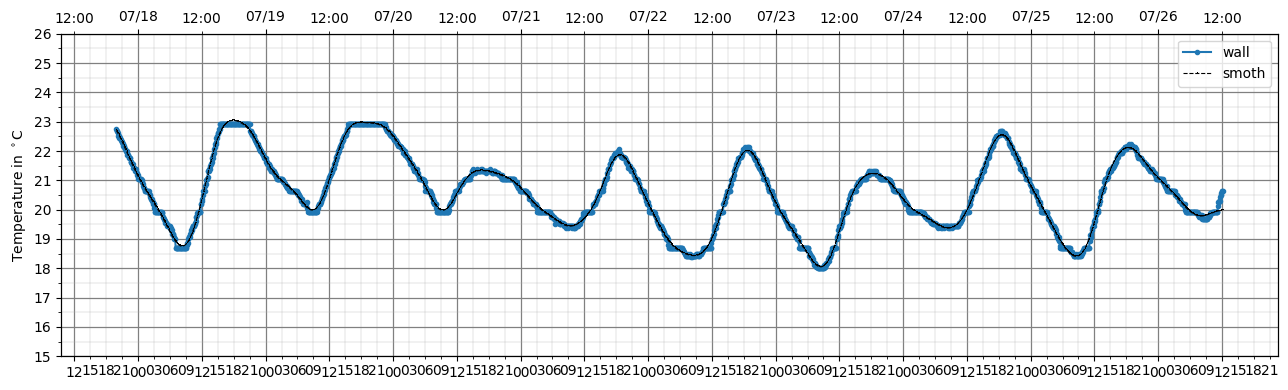

In [1]:
import pandas as pd 
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import mplcursors # track cursor
from scipy.signal import butter, filtfilt

with sqlite3.connect('home_temperature.db') as conn:
    cursor = conn.cursor()
    df = pd.read_sql_query("SELECT * FROM home", conn)

df.index = pd.to_datetime(df.time)
df.drop(columns=['time'], inplace=True)

# plotting
#matplotlib.use('GTK3Agg')
%matplotlib inline

# smoothing temperature considering trend from device
plotsize = 2500
#df = df[-2500:]

# interpolate data series for regular time-sample
df = df.resample('5T').last().interpolate(method='akima', order=3)
# define low pass and filter it
order = 4  # Filter order - Design the Butterworth filter
b, a = butter(order, 0.025, btype='low', analog=False)
# Apply the low-pass filter using filtfilt to preserve phase
interp_filtered = filtfilt(b, a, df['temp_out'])

# Create the plot
fig, ax = plt.subplots(figsize=(13,4))

# Plot the data
ax.plot(df.index[-plotsize:], df['temp_out'][-plotsize:], '.-', label='wall')
#ax.plot(df.index, df['temp_out'].ewm(span=10).mean(), ',--', label='ewm', linewidth=0.4)
ax.plot(df.index[-plotsize:], interp_filtered[-plotsize:], ',--', color='k', label='smoth', linewidth=0.8)

# Set the x-axis tick format
major_xtick_locator = mdates.AutoDateLocator(minticks=10)
ax.xaxis.set_major_locator(major_xtick_locator)  # Adjust the number of major ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Customize the format as needed
ax.xaxis.set_minor_locator(MultipleLocator(3 / 24))  # Set minor tick locations at 2 hourly intervals
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))  # Customize the format as needed
# Y axis
ax.yaxis.set_minor_locator(MultipleLocator(1/2))  # Set minor tick locations at 2 hourly intervals
ax.set_yticks(range(15, 27))
ax2 = ax.twiny()  # Create a twin Axes sharing the y-axis
ax2.set_xlim(ax.get_xlim())
major_xtick_locator_ = mdates.DayLocator()
ax2.xaxis.set_major_locator(major_xtick_locator_)  # Adjust the number of major ticks
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))  # Customize the format as needed
ax2.xaxis.set_minor_locator(MultipleLocator(12 / 24))  # Set minor tick locations at 2 hourly intervals
ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%H:00'))  # Customize the format as needed

ax.set_ylabel(r"Temperature in $^\circ$C")
ax.legend()
# Rotate x-axis tick labels for better visibility
#plt.xticks(rotation=45)
ax.grid(True, which='minor', axis='both', linestyle='-', linewidth=0.25)
ax.grid(True, which='major', axis='both', linestyle='-', linewidth=0.9, color='gray')
ax.yaxis.grid(True, linestyle='-', linewidth=0.9, color='gray')  # Enable y-axis grid lines

# cursor = mplcursors.cursor(hover=True)
# cursor.connect("add", lambda sel: sel.annotation.set(text="x: {:.2f}\ny: {:.2f}".format(sel.target[0], sel.target[1]), xy=(10, 10), xycoords='axes points'))

# Show the plot
plt.tight_layout()
plt.show()

In [3]:
df['y'] = interp_filtered
df.drop(columns=['temp_in', 'temp_out'], inplace=True)
df['ds'] = df.index

In [4]:
import pandas as pd
from prophet import Prophet

# Create a Prophet model
model = Prophet()

# Fit the model to the data
model.fit(df)

# Specify the number of periods to forecast
future_periods = 24  # Number of 5-minute intervals in a day

# Generate future dates for forecasting
future = model.make_future_dataframe(periods=future_periods, freq='5T')  # '5T' for 5-minute resolution

# Perform the forecastdf
forecast = model.predict(future[-20:])

# Retrieve the forecasted values
forecasted_values = forecast.tail(future_periods)['yhat']

# Print the forecasted values
print(forecasted_values)


19:03:33 - cmdstanpy - INFO - Chain [1] start processing
19:03:37 - cmdstanpy - INFO - Chain [1] done processing


0     21.721711
1     21.698464
2     21.674475
3     21.649770
4     21.624376
5     21.598321
6     21.571630
7     21.544331
8     21.516451
9     21.488016
10    21.459054
11    21.429591
12    21.399653
13    21.369266
14    21.338455
15    21.307246
16    21.275664
17    21.243733
18    21.211477
19    21.178920
Name: yhat, dtype: float64


In [5]:
future[-20:]

,ds
7173,2023-07-25 19:25:00
7174,2023-07-25 19:30:00
7175,2023-07-25 19:35:00
7176,2023-07-25 19:40:00
7177,2023-07-25 19:45:00
7178,2023-07-25 19:50:00
7179,2023-07-25 19:55:00
7180,2023-07-25 20:00:00
7181,2023-07-25 20:05:00
7182,2023-07-25 20:10:00


In [ ]:
# with sqlite3.connect('home_temperature.db') as conn:
#     df.to_sql(name='home', con=conn, if_exists='replace', index=True)